In [201]:
import torch
import pandas as pd

torch.__version__

'2.8.0+cu126'

In [202]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [203]:
from sklearn.model_selection import train_test_split

In [204]:
device = 'cpu'

In [205]:
data = pd.read_csv('../data/processed_smoke_detector.csv')
data.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],NC2.5,Fire Alarm,IsItDay?,Weekday_0,Weekday_1,Weekday_2
0,27.041,49.80,19.0,400.0,13059.0,19951,939.777,0.011,0,0,0,0,1
1,26.987,54.26,1.0,400.0,13078.0,19975,939.765,0.011,0,0,0,0,1
2,26.985,53.66,10.0,400.0,13068.0,19955,939.768,0.011,0,0,0,0,1
3,26.983,53.07,10.0,400.0,13069.0,19963,939.775,0.013,0,0,0,0,1
4,26.982,52.57,13.0,400.0,13072.0,19958,939.770,0.013,0,0,0,0,1


In [206]:
y, X = data['Fire Alarm'].values, data.drop(columns=['Fire Alarm']).values
#y = y.reshape(-1, 1)
X.shape, y.shape

((41247, 12), (41247,))

<Axes: >

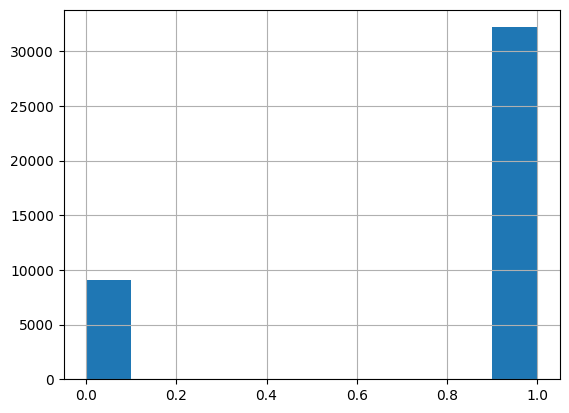

In [207]:
data['Fire Alarm'].hist()

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32997, 12), (8250, 12), (32997,), (8250,))

In [209]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [210]:
from torch.utils.data import TensorDataset, DataLoader

In [211]:
train_ds = TensorDataset(torch.from_numpy(X_train).type(torch.float32), torch.from_numpy(y_train).type(torch.long))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)

test_ds = TensorDataset(torch.from_numpy(X_test).type(torch.float32), torch.from_numpy(y_test))

test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

# Creating FCNN Classification model

In [212]:
import torch
import torch.nn as nn
import torch.optim as optim

In [213]:
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 2)
        # softmax is not used as CrossEntropyLoss combines CrossEntropyLossnn.LogSoftmax() and nn.NLLLoss() in one class

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)

In [214]:
class ClassificationNet(nn.Module):
    def __init__(self):
            super(ClassificationNet, self).__init__()
            self.fc1 = nn.Linear(12, 64)
            self.fc2 = nn.Linear(64, 128)
            self.fc3 = nn.Linear(128, 2)
            # softmax is not used as CrossEntropyLoss combines CrossEntropyLossnn.LogSoftmax() and nn.NLLLoss() in one class
            
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [215]:
model = ClassificationNet().to(device)
class_weights = torch.tensor([1.0, 5.0]).to(device) # weights for classes for FN -> min
loss_function = nn.CrossEntropyLoss(weight=class_weights).to(device)
learning_rate = 0.00001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [216]:
num_epochs = 100
epoch_loss = []
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_dl:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    epoch_loss.append(loss.item())

Epoch [1/100], Loss: 0.5254
Epoch [2/100], Loss: 0.3695
Epoch [3/100], Loss: 0.3103
Epoch [4/100], Loss: 0.2224
Epoch [5/100], Loss: 0.1343
Epoch [6/100], Loss: 0.0818
Epoch [7/100], Loss: 0.0664
Epoch [8/100], Loss: 0.0806
Epoch [9/100], Loss: 0.0571
Epoch [10/100], Loss: 0.0731
Epoch [11/100], Loss: 0.0310
Epoch [12/100], Loss: 0.0663
Epoch [13/100], Loss: 0.0286
Epoch [14/100], Loss: 0.0157
Epoch [15/100], Loss: 0.0403
Epoch [16/100], Loss: 0.0092
Epoch [17/100], Loss: 0.0095
Epoch [18/100], Loss: 0.0246
Epoch [19/100], Loss: 0.0585
Epoch [20/100], Loss: 0.0395
Epoch [21/100], Loss: 0.0222
Epoch [22/100], Loss: 0.0024
Epoch [23/100], Loss: 0.0122
Epoch [24/100], Loss: 0.0230
Epoch [25/100], Loss: 0.0166
Epoch [26/100], Loss: 0.0142
Epoch [27/100], Loss: 0.0134
Epoch [28/100], Loss: 0.0151
Epoch [29/100], Loss: 0.0063
Epoch [30/100], Loss: 0.0118
Epoch [31/100], Loss: 0.0011
Epoch [32/100], Loss: 0.0130
Epoch [33/100], Loss: 0.0045
Epoch [34/100], Loss: 0.0068
Epoch [35/100], Loss: 0

In [217]:
import matplotlib.pyplot as plt

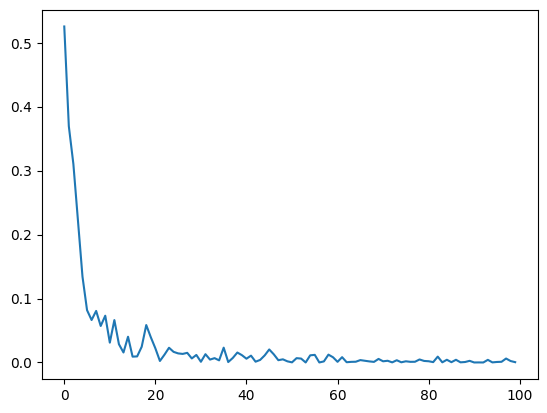

In [218]:
plt.plot(epoch_loss)

## Evaluation on test data

In [219]:
# model.eval()
# with torch.no_grad():
#     outputs = model(torch.from_numpy(X_test).float())
#     _, predicted_classes = torch.max(outputs, 1)

# predicted_classes_np = predicted_classes.numpy()

In [220]:
import numpy as np

In [221]:
model.eval()

with torch.no_grad():
    all_predictions = []
    all_labels = []

    for batch_x, batch_y in test_dl:
        outputs = model(batch_x)
        _, predicted_classes = torch.max(outputs, 1)
        
        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [222]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:\n")
report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
print(report)

print("\nConfusion Matrix:\n")
cm = confusion_matrix(all_labels, all_predictions)
print(cm)

Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99      1838
     Class 1       1.00      1.00      1.00      6412

    accuracy                           1.00      8250
   macro avg       1.00      0.99      1.00      8250
weighted avg       1.00      1.00      1.00      8250


Confusion Matrix:

[[1819   19]
 [   0 6412]]


## Evaluation on train data
If metrics on train >>> than on test => overfitting

In [223]:
model.eval()

with torch.no_grad():
    all_predictions = []
    all_labels = []

    for batch_x, batch_y in train_dl:
        outputs = model(batch_x)
        _, predicted_classes = torch.max(outputs, 1)
        
        all_predictions.extend(predicted_classes.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

In [224]:
from sklearn.metrics import confusion_matrix, classification_report

print("Classification Report:\n")
report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'])
print(report)

print("\nConfusion Matrix:\n")
cm = confusion_matrix(all_labels, all_predictions)
print(cm)

Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00      7212
     Class 1       1.00      1.00      1.00     25785

    accuracy                           1.00     32997
   macro avg       1.00      1.00      1.00     32997
weighted avg       1.00      1.00      1.00     32997


Confusion Matrix:

[[ 7154    58]
 [    0 25785]]
